- Diana Zaray Corado #191025
- Pablo Alejandro Méndez #19195
- Orlando Osberto Cabrera #19943
- Javier Alejandro Mejía Alecio #20304
- Erick Raúl Alvarez Melgar #20900

# Proyecto - Análisis Exploratorio

Guatemala es conocido como el país de la eterna primavera, debido a su diversidad de flora y fauna, además de contar
con un clima conocido como templado, es decir no existen climas extremos a lo largo del año. Sin embargo, así como
es conocido por su belleza natural, también es fuertemente reconocible por la corrupción y los bajos índices de calidad
de vida, y uno de ellos es el de mortalidad, la cual expresa la frecuencia con la cual ocurren las defunciones en una
población dada, en el caso de Guatemala, para el año 2019 fue de 4.72% (Datosmacro, 2021), es decir en promedio 5 muertes por cada 1000 habitantes.
A continuación se realizará un análisis exploratorio, sobre los datos de defunciones reportados por el Instituto Nacional de
Estadística de Guatemala -INE- de los años 2011 a 2020, y dentro de los cuales se pretende encontrar una situación problemática
la cual a su vez pueda ser resuelta con los datos analizados.

In [13]:
import pandas as pd
import numpy as np
import scipy.stats as sp
from scipy.stats import contingency
import seaborn as sns
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
import random
# Estilos
plt.style.use('ggplot')
sns.set_theme(palette=None)

In [2]:
# General functions
def calculate_frequency(data, column, index='index', head = False, size=20, use = False):
    data_f = pd.DataFrame({
        'frequency': data[column].value_counts(),
        'relative_frequency (%)': data[column].value_counts(normalize=True)*100,
        'relative_acc_frequency': data[column].value_counts(normalize=True).cumsum()
    })
    data_f.reset_index(level=[0], inplace=True)
    data_f.rename(columns={index:column}, inplace=True)
    if head:
        left_aligned_df = data_f.head(size).style.set_properties(**{'text-align': 'center'})
    else:
        left_aligned_df = data_f.style.set_properties(**{'text-align': 'center'})
    display(left_aligned_df)

    if use:
        return data_f

    return None

def is_normal(column, tolerancia=0.05):
    return sp.normaltest(column).pvalue > tolerancia

In [3]:
# Cargar los datos
deaths = pd.read_csv('final.csv')
# Como ya se cuenta con la causa de muerte (categorizada) la descripción sale sobrando
# De igual forma, el periodo de edad se puede obtener mediante la edad así que es info redundante
deaths = deaths.loc[:, deaths.columns != 'Perdif']
deaths = deaths.loc[:, deaths.columns != 'caudef.descrip']

C:\Users\Zaray\AppData\Local\Temp\ipykernel_14408\1461672132.py:2: DtypeWarning: Columns (7,12,18,22,26) have mixed types. Specify dtype option on import or set low_memory=False.
  deaths = pd.read_csv('final.csv')


# Exploración de los datos

## ¿Cuáles son los datos?
Comience describiendo cuantas variables y observaciones tiene disponibles, el tipo de cada una de las variables.

In [44]:
deaths.shape

(809296, 28)

Para la elaboración del análisis se cuenta con los datos encontrados en la página del Instituto Nacional de Estadística
de Guatemala -INE- para las defunciones del rango de años desde 2011 a 2020. Al unificar los datos provistos en cada uno
de los años, en total, se cuenta con 809296 observaciones y con un total de 28 variables.

### Clasificación de variables
**Cuantitativas discretas**
- EDADIF → Edad del difunto

**Cualitativas Ordinal**
- ESCODIF → Escolaridad del difunto

**Cualitativa Nominal**
- DEPREG → Departamento de registro
- MUPREG → Municipio de registro
- MESREG → Mes de registro
- AÑOREG → Año de registro
- DEPOCU → Departamento de ocurrencia
- MUPOCU → Municipio de ocurrencia
- AREGAG → Área geográfica de ocurrencia
- SEXO
- DIAOCU → Día de ocurrencia
- MESOCU → Mes de ocurrencia
- AÑOOCU → Año de ocurrencia
- PUEDIF → Pueblo de pertenencia del difunto
- ECIDIF → Estado civil del difunto
- CIUODIF → Ocupación del difunto
- PNADIF → País de nacimiento
- DNADIF → Departamento de nacimiento
- MNADIF → Municipio de nacimiento
- NACDIF → Nacionalidad del difunto
- PREDIF → País de residencia
- DREDIF → Departamento de residencia
- MREDIF → Municipio de residencia
- CAUDEF → Causa de defunción
- ASIST → Asistencia recibida
- OCUR → Sitio de ocurrencia
- CERDEF → Quién certifica

## Preprocesamiento 
Análisis de valores atípicos y tratamientos de valores faltantes

In [4]:
# Debido a que edad se tomará como variable cuantitativa será necesario reeplazar el valor de ignorado por -1 para que todos
# los datos estén en el mismo formato
deaths['Edadif'] = deaths['Edadif'].replace(['Ignorado'], -1)
deaths['Edadif'] = deaths['Edadif'].astype('int')

In [ ]:
#Se observó que los datos que registraban los departamentos en algunos años se escribían con ascento y en otros no


In [21]:
deaths['cause'] = deaths['Caudef'].copy()

# deaths.cause = deaths.cause.str.replace(r'\d+.*', r'\1', regex=True)
repl = {r'([AB])(\d+.*)' : r'AB',
        r'(C)(\d+.*)' : r'CD',
        r'(D[0-4])(\d+.*)' : r'CD',
        r'(D[5-8])(\d+.*)' : r'DD',
        r'(E)(\d+.*)' : r'EE',
        r'(F)(\d+.*)' : r'FF',
        r'(G)(\d+.*)' : r'GG',
        r'(H[0-5])(\d+.*)' : r'HA',
        r'(H[6-9])(\d+.*)' : r'HB',
        r'(I)(\d+.*)' : r'II',
        r'(J)(\d+.*)' : r'JJ',
        r'(K)(\d+.*)' : r'KK',
        r'(L)(\d+.*)' : r'LL',
        r'(M)(\d+.*)' : r'MM',
        r'(N)(\d+.*)' : r'NN',
        r'(O)(\d+.*)' : r'OO',
        r'(P)(\d+.*)' : r'PP',
        r'(Q)(\d+.*)' : r'QQ',
        r'(R[0-8])(\d+.*)' : r'RR',
        r'(R9)(\d+.*)' : r'RA',
        r'([ST])(\d+.*)' : r'ST',
        r'([VWXY])(\d+.*)' : r'VY',
        r'([Z])(\d+.*)' : r'ZZ',
        r'([U])(\d+.*)' : r'UU',
        }
deaths.cause = deaths['cause'].replace(repl, regex=True)
deaths['cause']

0         II
1         UU
2         RA
3         PP
4         UU
          ..
809291    AB
809292    AB
809293    AB
809294    AB
809295    AB
Name: cause, Length: 809296, dtype: object

Para utilizar las causas de las muertes en los análisis de los datos, debido a que existían varias categorías,
se decidió agregar una capa extra de abstracción de las causas, esto principalmente para analizar las causas de muertes
como naturales o por accidentes y sobre enfermedades generales. La nueva categorización de las causas de muerte se guardó
en una nueva columna con el nombre de *cause* y sus valores identifican las siguientes causas:
- AB → Enfermedades infeccionas y parasitarias
- CD → Neoplasias (Cáncer)
- DD → Enfermedades de la sangre y órganos hematopoyéticos y ciertos trastornos que afectan al mecanismo inmunológico
- EE → Enfermedades endocrinas, nutricionales y metabólicas
- GG → Enfermedades del sistema nervioso
- H0 → Enfermedades del ojo y sus anexos
- H6 → Enfermedades del oído y de la apósfisis mastoides
- II → Enfermedades del aparato circulatorio
- JJ → Enfermedades del aparato respiratorio
- KK → Enfermedades del aparato digestivo
- LL → Enfermedades de la piel y del tejido subcutáneo
- MM → Enfermedades del aparato musculoesquelético y del tejido conectivo
- NN → Enfermedades del aparato genitourinario
- OO → Embarazo, parto, puerperio
- PP → Ciertas afecciones originadas en el periodo perinatal
- QQ → Malformaciones congénitas, deformidades y anomalías cromosómicas
- RR → Sintomas, signos y resultados anormales de pruebas complementarias, no clasificados bajo otro concepto
- ST → Lesiones traumáticas, envenenamiento y otras consecuencias de causas externas
- VY → Causas externas de morbilidad
- ZZ → Factores que influyen en el estado de salud y contacto con los servicios sanitarios
- UU → Propósitos especiales

## Variables cuantitativas y su distribución
Haga un resumen de las variables numéricas e investigue si siguen una distribución normal.


In [47]:
display(deaths['Edadif'].describe())

if is_normal(deaths['Edadif']):
    print(f'La edad tiene una distribución normal.')
else:
     print(f'La edad NO tiene una distribución normal.')

count    809296.000000
mean         53.701852
std          28.428669
min          -1.000000
25%          31.000000
50%          60.000000
75%          78.000000
max         122.000000
Name: Edadif, dtype: float64

La edad NO tiene una distribución normal.


Como se puede notar en los resultados anteriores, la edad promedio para las muertes reportadas de 2011 a 2020 es de
aproximadamente 54 años, eso quiere decir que de los datos reportados, la mayoría están en un rango de fallecer a los
53 a 54 años, esto también se puede notar en que el 50% de los difuntos están por debajo de 60 años de estos un 25% se
encuentra por debajo de 31.

## Variables cualitativas y su frecuencia
Elabore tablas de frecuencia para las variables categóricas, escriba lo que vaya encontrando.

### Departamento de registro
Guatemala presenta la mayor cantidad de muertes registradas. Esto era de esperarse, puesto que la densidad poblacional es
mucho mayor en comparación con los demás departamentos. Luego le sigue Quetzaltenango, al igual que Guatemala, este es
un departamento con una alta densidad poblacional.

,Depreg,frequency,relative_frequency (%),relative_acc_frequency
0,Guatemala,238866,29.515282,0.295153
1,Quetzaltenango,49558,6.123594,0.356389
2,Alta Verapaz,49071,6.063418,0.417023
3,San Marcos,47997,5.930710,0.476330
4,Escuintla,46155,5.703105,0.533361
5,Huehuetenango,45374,5.606601,0.589427
6,Quiché,32499,4.015712,0.629584
7,Suchitepequez,30460,3.763765,0.667222
8,Chimaltenango,28316,3.498843,0.702210
9,Jutiapa,24779,3.061797,0.732828


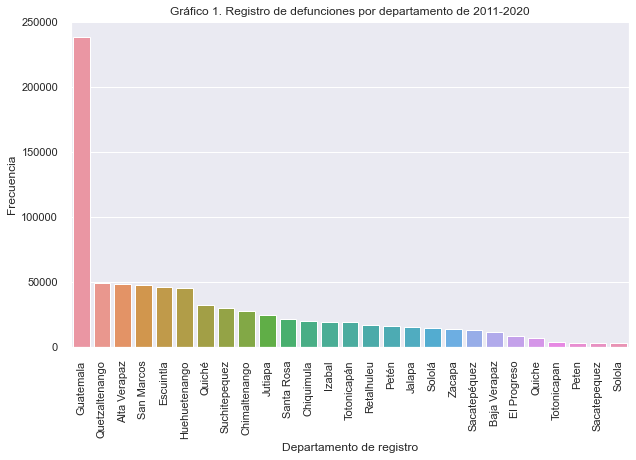

In [48]:
depreg = calculate_frequency(deaths, 'Depreg', use=True)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Depreg', y='frequency', data=depreg)
ax.set(title='Gráfico 1. Registro de defunciones por departamento de 2011-2020',
       xlabel= 'Departamento de registro',
       ylabel='Frecuencia')
plt.xticks(rotation=90)
plt.show()

del depreg, ax

### Municipio de registro

In [49]:
# Para no mostrar muchos datos, solo poner un head de 20
calculate_frequency(deaths, 'Mupreg', head=True)

,Mupreg,frequency,relative_frequency (%),relative_acc_frequency
0,Guatemala,200377,24.759421,0.247594
1,Quetzaltenango,18111,2.237871,0.269973
2,Cobán,12975,1.603245,0.286005
3,Escuintla,12595,1.556291,0.301568
4,Mazatenango,8470,1.046589,0.312034
5,Chiquimula,8411,1.039298,0.322427
6,Huehuetenango,8278,1.022864,0.332656
7,Coatepeque,8222,1.015945,0.342815
8,Cuilapa,8165,1.008902,0.352904
9,Jalapa,8088,0.999387,0.362898


### Mes de registro

In [50]:
calculate_frequency(deaths, 'Mesreg')

,Mesreg,frequency,relative_frequency (%),relative_acc_frequency
0,Julio,74719,9.232592,0.092326
1,Enero,73762,9.114341,0.183469
2,Agosto,70181,8.671858,0.270188
3,Octubre,69355,8.569794,0.355886
4,Mayo,67973,8.399028,0.439876
5,Noviembre,66530,8.220725,0.522083
6,Septiembre,66261,8.187486,0.603958
7,Junio,65637,8.110382,0.685062
8,Abril,64861,8.014497,0.765207
9,Diciembre,64323,7.948019,0.844687


### Año de registro
La mayor cantidad de muertes se dió en el 2020. Podríamos relacionarlo al inicio de la Pandemia, puesto que hubo un aumento
a comparación del 2019 de 9,624 muertes

In [51]:
calculate_frequency(deaths, 'Añoreg')

,Añoreg,frequency,relative_frequency (%),relative_acc_frequency
0,2020,95100,11.750954,0.117510
1,2019,85476,10.561772,0.223127
2,2018,82755,10.225554,0.325383
3,2016,82420,10.184160,0.427224
4,2017,81475,10.067392,0.527898
5,2015,81040,10.013641,0.628035
6,2014,77582,9.586357,0.723898
7,2013,76618,9.467241,0.818571
8,2012,72115,8.910831,0.907679
9,2011,71144,8.790850,0.995588


### Departamento de ocurrencia

In [52]:
calculate_frequency(deaths, 'Depocu')

,Depocu,frequency,relative_frequency (%),relative_acc_frequency
0,Guatemala,237388,29.332655,0.293327
1,Quetzaltenango,50797,6.276690,0.356093
2,Alta Verapaz,48846,6.035616,0.416450
3,Escuintla,47028,5.810976,0.474559
4,San Marcos,47003,5.807887,0.532638
5,Huehuetenango,45282,5.595233,0.588591
6,Quiché,32167,3.974689,0.628337
7,Suchitepequez,30514,3.770438,0.666042
8,Chimaltenango,28161,3.479691,0.700839
9,Jutiapa,23582,2.913891,0.729978


### Municipio de ocurrencia

In [53]:
calculate_frequency(deaths, 'Mupocu', head=True)

,Mupocu,frequency,relative_frequency (%),relative_acc_frequency
0,Guatemala,158214,19.549584,0.195496
1,Mixco,20192,2.495008,0.220446
2,Escuintla,19321,2.387384,0.244320
3,Quetzaltenango,18274,2.258012,0.266900
4,Villa Nueva,13046,1.612018,0.283020
5,Cobán,12886,1.592248,0.298943
6,Mazatenango,10429,1.288651,0.311829
7,Coatepeque,9326,1.152360,0.323353
8,Huehuetenango,9296,1.148653,0.334839
9,Amatitlán,9182,1.134566,0.346185


### Área geográfica de ocurrencia

In [54]:
calculate_frequency(deaths, 'Areag')

,Areag,frequency,relative_frequency (%),relative_acc_frequency
0,Urbano,295064,54.177561,0.541776
1,Rural,239389,43.954912,0.981325
2,Ignorado,10171,1.867527,1.000000


### Sexo

In [55]:
calculate_frequency(deaths, 'Sexo')

,Sexo,frequency,relative_frequency (%),relative_acc_frequency
0,Hombre,454900,56.209347,0.562093
1,Mujer,354396,43.790653,1.000000


### Día de ocurrencia

In [56]:
calculate_frequency(deaths, 'Diaocu')

,Diaocu,frequency,relative_frequency (%),relative_acc_frequency
0,1,27544,3.403452,0.034035
1,5,27062,3.343894,0.067473
2,4,27045,3.341793,0.100891
3,2,27043,3.341546,0.134307
4,25,26899,3.323753,0.167544
5,10,26857,3.318563,0.200730
6,15,26822,3.314239,0.233872
7,6,26769,3.307690,0.266949
8,3,26736,3.303612,0.299985
9,16,26682,3.296940,0.332955


### Mes de ocurrencia

Como se puede observar en la **gráfica 7**, los meses 3 con mayores defunciones son:
- Julio con 73553 muertes reportas,
- Agosto con 69865
- Diciembre con 69332

Es curioso ver como en el mes de julio es donde se dan la mayor cantidad de muertes. Podemos relacionarlo con el pago de
la bonificación del bono 14, ya que en este mes las extorsiones aumentan. Esto nos indica que el índice de violencia puede
ser superior por dicho bono, por lo que las muertes aumentan. Para julio de 2020 además, se tuvieron picos en la pandemia
Covid-19, lo que quizá pudo darle peso a esta variable.

,Mesocu,frequency,relative_frequency (%),relative_acc_frequency
0,Julio,73553,9.088516,0.090885
1,Agosto,69865,8.632812,0.177213
2,Diciembre,69332,8.566952,0.262883
3,Octubre,68468,8.460193,0.347485
4,Enero,68213,8.428684,0.431772
5,Junio,67813,8.379258,0.515564
6,Marzo,66918,8.268668,0.598251
7,Septiembre,66696,8.241237,0.680663
8,Mayo,66551,8.223320,0.762896
9,Noviembre,66100,8.167593,0.844572


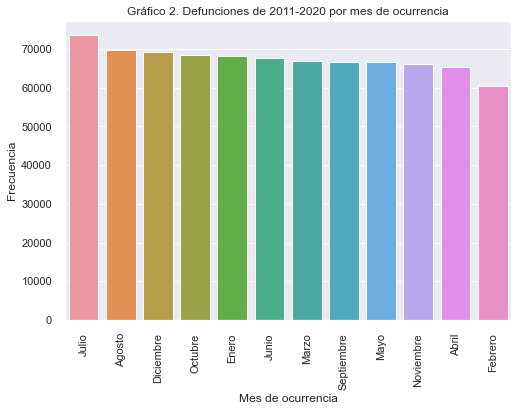

In [57]:
mesocu = calculate_frequency(deaths, 'Mesocu', use=True)

ax = sns.barplot(x='Mesocu', y='frequency', data=mesocu);
ax.set(title='Gráfico 2. Defunciones de 2011-2020 por mes de ocurrencia',
       xlabel= 'Mes de ocurrencia',
       ylabel='Frecuencia')
plt.xticks(rotation=90)
plt.show()

del mesocu, ax

### Año de ocurrencia

In [58]:
calculate_frequency(deaths, 'Añoocu')

,Añoocu,frequency,relative_frequency (%),relative_acc_frequency
0,2020,96001,11.862285,0.118623
1,2019,85600,10.577094,0.224394
2,2018,83071,10.264600,0.327040
3,2016,82565,10.202077,0.429061
4,2017,81726,10.098407,0.530045
5,2015,80876,9.993377,0.629978
6,2014,77807,9.614158,0.726120
7,2013,76639,9.469836,0.820818
8,2012,72657,8.977803,0.910596
9,2011,72354,8.940363,1.000000


### Pueblo de pertenencia

In [59]:
calculate_frequency(deaths, 'Puedif')

,Puedif,frequency,relative_frequency (%),relative_acc_frequency
0,No indigena,404695,50.005808,0.500058
1,Indigena,220157,27.203520,0.772093
2,Ignorado,177070,21.879510,0.990888
3,Otro,7374,0.911162,1.000000


### Estado civil del difunto

#### ¿Cuál es el estado civil predominante en las muertes?
Como se puede notar en el gráfico inferior, el estado civil predominante en las defunciones es el soltero. Este es un resultado esperado, ya que
dentro de los datos se encuentran personas de todas las edades, por lo que muchos de los fallecidos son aún niños cuando mueren, por lo tal, su
estado civil es soltero, y también están todos aquellos que mueren a una edad relativamente joven por lo que aún no han contraído matrimonio.

,Ecidif,frequency,relative_frequency (%),relative_acc_frequency
0,Soltero,508861,62.876994,0.628770
1,Casado,286024,35.342322,0.982193
2,Unido,7923,0.978999,0.991983
3,Ignorado,6488,0.801684,1.000000


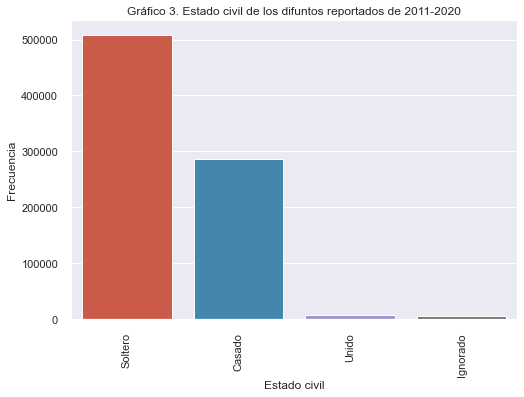

In [60]:
estado = calculate_frequency(deaths, 'Ecidif', use=True)

ax = sns.barplot(x='Ecidif',y='frequency',data=estado)
ax.set(title='Gráfico 3. Estado civil de los difuntos reportados de 2011-2020',
       xlabel= 'Estado civil',
       ylabel='Frecuencia')
plt.xticks(rotation=90)
plt.show()

del estado, ax

### Escolaridad del difunto
¿Influye el tener una educación superior a reducir el número de defunciones?
La mayoría de muertes se dan en personas con escolaridad nula. Es interesante observar como estudiantes
universitarios y de posgrado son los que presentan la menor cantidad de muertes en los últimos 10 años.

,Escodif,frequency,relative_frequency (%),relative_acc_frequency
0,Ninguna,438866,54.228119,0.542281
1,Primaria,207679,25.661686,0.798898
2,Ignorado,64824,8.009925,0.878997
3,Diversificado,49919,6.168201,0.940679
4,Básico,35846,4.429282,0.984972
5,Universitario,11944,1.475851,0.999731
6,Post grado,218,0.026937,1.000000


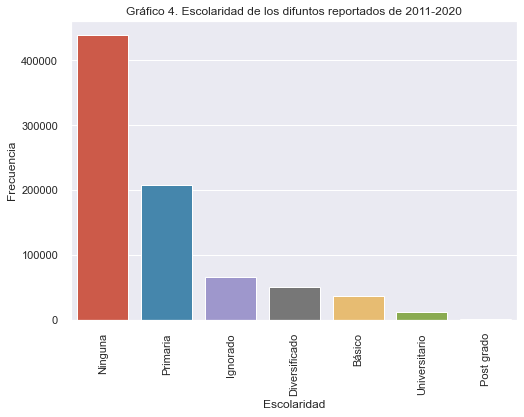

In [61]:
escodif = calculate_frequency(deaths, 'Escodif', use=True)

ax = sns.barplot(x= 'Escodif', y='frequency', data=escodif)
ax.set(title='Gráfico 4. Escolaridad de los difuntos reportados de 2011-2020',
       xlabel= 'Escolaridad',
       ylabel='Frecuencia')
plt.xticks(rotation=90)
plt.show()

del escodif, ax

### Ocupación del difunto

In [62]:
calculate_frequency(deaths, 'Ciuodif', head=True)

,Ciuodif,frequency,relative_frequency (%),relative_acc_frequency
0,No especificado en otro grupo,404982,50.041270,0.500413
1,"Peones agropecuarios, pesqueros y forestales",127064,15.700559,0.657418
2,Agricultores y trabajadores calificados de explotaciones agropecuarias con destino al mercado,75575,9.338363,0.750802
3,Ignorado,61801,7.636390,0.827166
4,Vendedores,27354,3.379975,0.860966
5,Oficiales y operarios de la construcción excluyendo electricistas,17402,2.150264,0.882468
6,Conductores de vehículos y operadores de equipos pesados móviles,13684,1.690852,0.899377
7,"Operarios y oficiales de procesamiento de alimentos, de la confección, ebanistas, otros artesanos y afines",9466,1.169659,0.911073
8,Profesionales de la enseñanza,8543,1.055609,0.921629
9,"Oficiales y operarios de la metalurgia, la construcción mecánica y afines",8338,1.030278,0.931932


### País de nacimiento

In [63]:
calculate_frequency(deaths, 'Pnadif', head=True)

,Pnadif,frequency,relative_frequency (%),relative_acc_frequency
0,Guatemala,725117,98.395396,0.983954
1,Ignorado,4891,0.663689,0.990591
2,El Salvador,2672,0.362579,0.994217
3,Honduras,963,0.130675,0.995523
4,Nicaragua,604,0.081960,0.996343
5,México,567,0.076940,0.997112
6,Estados Unidos De América,364,0.049393,0.997606
7,España,239,0.032431,0.997931
8,Estados Unidos de América,180,0.024425,0.998175
9,Colombia,149,0.020219,0.998377


### Departamento de nacimiento

In [64]:
calculate_frequency(deaths, 'Dnadif')

,Dnadif,frequency,relative_frequency (%),relative_acc_frequency
0,Guatemala,135407,16.731455,0.167315
1,San Marcos,58711,7.254577,0.239860
2,Alta Verapaz,55594,6.869427,0.308555
3,Quetzaltenango,50619,6.254695,0.371102
4,Huehuetenango,50190,6.201686,0.433118
5,Escuintla,41228,5.094304,0.484061
6,Jutiapa,40376,4.989028,0.533952
7,Quiché,39436,4.872877,0.582681
8,Suchitepequez,34727,4.291013,0.625591
9,Chimaltenango,34292,4.237263,0.667963


### Municipio de nacimiento

In [65]:
calculate_frequency(deaths, 'Mnadif', head=True)

,Mnadif,frequency,relative_frequency (%),relative_acc_frequency
0,Guatemala,85342,10.545215,0.105452
1,San Pedro Carchá,12515,1.546406,0.120916
2,Escuintla,11920,1.472885,0.135645
3,Quetzaltenango,11846,1.463741,0.150282
4,Cobán,10947,1.352657,0.163809
5,Jutiapa,10425,1.288157,0.176691
6,Jalapa,9933,1.227363,0.188964
7,Totonicapán,9501,1.173983,0.200704
8,San Juan Sacatepéquez,8772,1.083905,0.211543
9,Chiquimula,7752,0.957870,0.221122


### Nacionalidad del difunto

In [66]:
calculate_frequency(deaths, 'Nacdif')

,Nacdif,frequency,relative_frequency (%),relative_acc_frequency
0,Guatemala,795884,98.342757,0.983428
1,Ignorado,5711,0.705675,0.990484
2,El Salvador,2944,0.363773,0.994122
3,Honduras,1083,0.133820,0.995460
4,Nicaragua,666,0.082294,0.996283
5,México,625,0.077228,0.997055
6,Estados Unidos De América,364,0.044977,0.997505
7,España,263,0.032497,0.997830
8,Estados Unidos de América,239,0.029532,0.998126
9,Colombia,175,0.021624,0.998342


### País de residencia

In [67]:
calculate_frequency(deaths, 'Predif')

,Predif,frequency,relative_frequency (%),relative_acc_frequency
0,Guatemala,679028,92.141308,0.921413
1,Ignorado,56788,7.705898,0.998472
2,El Salvador,340,0.046137,0.998933
3,Estados Unidos De América,229,0.031074,0.999244
4,Honduras,131,0.017776,0.999422
5,México,125,0.016962,0.999592
6,721,92,0.012484,0.999716
7,Nicaragua,70,0.009499,0.999811
8,Belice,48,0.006513,0.999877
9,Estados Unidos de América,33,0.004478,0.999921


### Departamento de residencia

In [68]:
calculate_frequency(deaths, 'Dredif')

,Dredif,frequency,relative_frequency (%),relative_acc_frequency
0,Guatemala,186794,23.081048,0.230810
1,Ignorado,62239,7.690511,0.307716
2,San Marcos,47246,5.837913,0.366095
3,Alta Verapaz,45726,5.650096,0.422596
4,Escuintla,43787,5.410505,0.476701
5,Quetzaltenango,43312,5.351812,0.530219
6,Huehuetenango,42618,5.266058,0.582879
7,Quiché,30555,3.775504,0.620634
8,Suchitepequez,29625,3.660589,0.657240
9,Chimaltenango,27865,3.443116,0.691672


### Municipio de residencia

In [69]:
calculate_frequency(deaths, 'Mredif', head=True)

,Mredif,frequency,relative_frequency (%),relative_acc_frequency
0,Guatemala,90500,11.182559,0.111826
1,Ignorado,62239,7.690511,0.188731
2,Mixco,23527,2.907095,0.217802
3,Villa Nueva,17847,2.205250,0.239854
4,Quetzaltenango,11145,1.377123,0.253625
5,Escuintla,10471,1.293841,0.266564
6,San Juan Sacatepéquez,9344,1.154584,0.278110
7,San Pedro Carchá,9293,1.148282,0.289592
8,Cobán,8461,1.045477,0.300047
9,Jalapa,7855,0.970597,0.309753


### Causa de defunción

In [70]:
calculate_frequency(deaths, 'cause', head=True, size=30)

,cause,frequency,relative_frequency (%),relative_acc_frequency
0,II,130082,16.073476,0.160735
1,VY,118172,14.601827,0.306753
2,JJ,91367,11.289689,0.419650
3,EE,82081,10.142272,0.521073
4,CD,81846,10.113234,0.622205
5,KK,61417,7.588941,0.698094
6,RA,50073,6.187229,0.759967
7,AB,41483,5.125813,0.811225
8,NN,34084,4.211562,0.853340
9,RR,32146,3.972094,0.893061


### Asistencia recibida

#### ¿Cuál es el tipo de asistencia recibida predominante en las defunciones?
Como se puede observar en el gráfico 2, en un 48% de las defunciones no se recibió ningún tipo de asistencia, sin
embargo, algo interesante a notar es que un 47% de los difuntos recibieron asistencia médica. Dejando así solo aproximadamente
un 1% de diferencia entre la asistencia predominante y la segunda más utilizada.


,Asist,frequency,relative_frequency (%),relative_acc_frequency
0,Ninguna,397811,49.155192,0.491552
1,Médica,380022,46.957108,0.961123
2,Empírica,18318,2.263449,0.983757
3,Ignorado,9482,1.171636,0.995474
4,Paramédica,3028,0.374152,0.999215
5,Comadrona,635,0.078463,1.000000


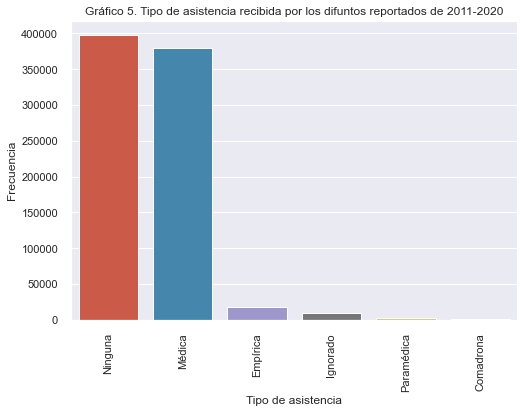

In [73]:
assist = calculate_frequency(deaths, 'Asist', use=True)

ax = sns.barplot(x='Asist',y='frequency',data=assist)
ax.set(title='Gráfico 5. Tipo de asistencia recibida por los difuntos reportados de 2011-2020',
       xlabel= 'Tipo de asistencia',
       ylabel='Frecuencia')
plt.xticks(rotation=90)
plt.show()
del assist, ax

### Sitio de ocurrencia

### ¿Cuál es la proporción de personas que mueren en sus casas con respecto a las que mueren en hospitales?
Como se puede observar en el **gráfico 3** el principal sitio de ocurrencia de las muertes en en los domicilios de los difuntos, estos
representando un 69% de las muertes reportadas, y es destacable notar que únicamente un 21% de los difuntos fallecieron en el hospital.


,Ocur,frequency,relative_frequency (%),relative_acc_frequency
0,Domicilio,492731,60.883904,0.608839
1,Hospital público,167440,20.689587,0.815735
2,Ignorado,45301,5.597581,0.871711
3,Seguro social,41581,5.137922,0.923090
4,Vía pública,25316,3.128151,0.954371
5,Hospital privado,22830,2.820970,0.982581
6,Otro,11815,1.459911,0.997180
7,Centro de salud,2221,0.274436,0.999925
8,Lugar de trabajo,61,0.007537,1.000000


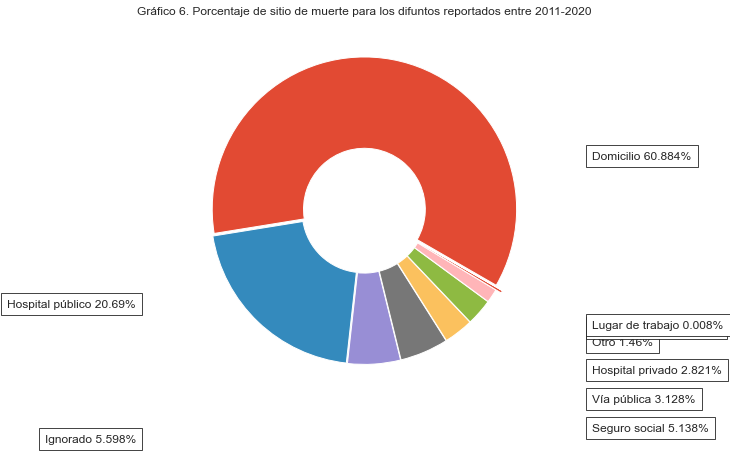

In [74]:
ocur = calculate_frequency(deaths, 'Ocur', use=True)

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(aspect="equal"))
explode = (0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.05, 0.05)
wedges, texts = ax.pie(ocur['relative_frequency (%)'], wedgeprops=dict(width=0.6), startangle=-30, explode=explode)

bbox_props = dict(boxstyle="square,pad=0.5", fc="w", ec="k", lw=0.77)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/5. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(ocur['Ocur'][i] + ' ' + str(round(ocur['relative_frequency (%)'][i], 3)) + '%', xy=(x, y), xytext=(1.5*np.sign(x), 1.5*y),
                horizontalalignment=horizontalalignment, **kw)
plt.title('Gráfico 6. Porcentaje de sitio de muerte para los difuntos reportados entre 2011-2020')
plt.show()

del ocur, fig, ax, explode, wedges, texts, bbox_props, kw, 

### Quién certifica

In [ ]:
calculate_frequency(deaths, 'Cerdef')

,Cerdef,frequency,relative_frequency (%),relative_acc_frequency
0,Médico,452385,55.898583,0.558986
1,Ignorado,295654,36.532245,0.924308
2,Medico,49374,6.100858,0.985317
3,Paramédico,5217,0.644634,0.991763
4,Autoridad,5054,0.624493,0.998008
5,Paramedico,1612,0.199185,1.000000


## Definiendo elementos clave
Cruce las variables que considere que son las más importantes para hallar los elementos clave que lo pueden llevar a
comprender lo que está causando el problema encontrado.

Para hacer el cruce de las variables y comprender si existe cierta asociación entre dichas variables se utilizará Cramer´s V
la cual es una medida de la longitud entre variables categóricas, básicamente mide la relación entre las variables. Su valor
varía de 0 a 1, donde 0 indica que no existe ningún tipo de asociación entre las variables y 1 que sí existe asociación entre
las mismas. Por otro lado, también se utilizarán las tablas de contingencia para hacer el "cruce" de las variables.

Durante el análisis exploratorio de los datos y mediante las diversas preguntas que se plantearon para conocer dichos datos
se pudo encontrar que existe una gran parte de las defunciones las cuales NO reciben asistencia médica, y esto es más notorio
cuando se habla de asistencia médica por pueblo de pertenencia. Por lo tal, se evaluará únicamente la asociación de las variables
con respecto al tipo de asistencia que reciben.

In [ ]:
depreg = pd.crosstab(deaths['Depreg'], deaths['Asist'])
print(depreg)
print('Asociación: ', contingency.association(depreg))

del depreg


Asist           Comadrona  Empírica  Ignorado  Médica  Ninguna  Paramédica
Depreg                                                                    
Alta Verapaz          224      7429       268   11736    28933         481
Baja Verapaz           21       652       112    2282     8901          88
Chimaltenango          30       131      1046   10211    16791         107
Chiquimula              3       113       380    5454    14513          33
El Progreso             2        26        47    3791     4362         157
Escuintla               7       488       801   19368    25379         112
Guatemala              20       113      1645  201207    35560         321
Huehuetenango         115      1313       776   10565    32390         215
Izabal                  1       221       275    7604    11097          80
Jalapa                  1       199       535    3461    11816          29
Jutiapa                 9      1415       309    8808    14063         175
Peten                   1

In [ ]:
mupreg = pd.crosstab(deaths['Mupreg'], deaths['Asist'])
print(mupreg)
print('Asociación: ', contingency.association(mupreg))

del mupreg

Asist        Comadrona  Empírica  Ignorado  Médica  Ninguna  Paramédica
Mupreg                                                                 
Acatenango           0         2        11     123      742           0
Agua Blanca          0         5         3     269      564           4
Aguacatán           12         8         0     265     1911           7
Almolonga            2         1         1     678       31           0
Alotenango           4        63        13     231      655          12
...                ...       ...       ...     ...      ...         ...
Zacualpa             7         9         2     198     1183           2
Zapotitlán           1         1         2      54      310          16
Zaragoza             2         1        17     217      579           3
Zunil                0        24         2     198      449           4
Zunilito             0         1         2      62      260           1

[334 rows x 6 columns]
Asociación:  0.42992907430786664


In [ ]:
mesreg = pd.crosstab(deaths['Mesreg'], deaths['Asist'])
print(mesreg)
print('Asociación: ', contingency.association(mesreg))

del mesreg

Asist       Comadrona  Empírica  Ignorado  Médica  Ninguna  Paramédica
Mesreg                                                                
Abril              40      1447       621   30524    32001         228
Agosto             65      1526       951   33445    33944         250
Diciembre          38      1379       894   30932    30835         245
Enero              68      1793       813   32665    38108         315
Febrero            55      1575       715   28294    31665         245
Julio              47      1545       805   36301    35763         258
Junio              44      1422       696   31743    31530         202
Marzo              56      1455       586   30032    30760         256
Mayo               55      1519       648   31789    33706         256
Noviembre          63      1501       957   30918    32831         260
Octubre            47      1631       934   32356    34123         264
Septiembre         57      1525       862   31023    32545         249
Asocia

In [ ]:
areag = pd.crosstab(deaths['Areag'], deaths['Asist'])
print(areag)
print('Asociación: ', contingency.association(areag))

del areag


Asist     Comadrona  Empírica  Ignorado  Médica  Ninguna  Paramédica
Areag                                                               
Ignorado          6       206        33    2055     7788          83
Rural           379     10230       599   22367   204918         896
Urbano           57      2351       440  222758    68453        1005
Asociación:  0.46653290840140615


In [ ]:
sexo = pd.crosstab(deaths['Sexo'], deaths['Asist'])
print(sexo)
print('Asociación: ', contingency.association(sexo))

del sexo


Asist   Comadrona  Empírica  Ignorado  Médica  Ninguna  Paramédica
Sexo                                                              
Hombre        244      9465      6777  207723   228798        1893
Mujer         391      8853      2705  172299   169013        1135
Asociación:  0.04750906347691493


In [ ]:
puedif = pd.crosstab(deaths['Puedif'], deaths['Asist'])
print(puedif)
print('Asociación: ', contingency.association(puedif))

del puedif


Asist        Comadrona  Empírica  Ignorado  Médica  Ninguna  Paramédica
Puedif                                                                 
Ignorado           240      3809      1804   94510    76024         683
Indigena           335      9672      2179   52191   154904         876
No indigena         56      4734      5308  228959   164188        1450
Otro                 4       103       191    4362     2695          19
Asociación:  0.17013016689516938


In [ ]:
ecidif = pd.crosstab(deaths['Ecidif'], deaths['Asist'])
print(ecidif)
print('Asociación: ', contingency.association(ecidif))

del ecidif


Asist     Comadrona  Empírica  Ignorado  Médica  Ninguna  Paramédica
Ecidif                                                              
Casado          156      6773      3075  140751   134256        1013
Ignorado          3        21       281    3242     2917          24
Soltero         471     11359      6071  233790   255208        1962
Unido             5       165        55    2239     5430          29
Asociación:  0.03394634910321279


In [ ]:
escodif = pd.crosstab(deaths['Escodif'], deaths['Asist'])
print(escodif)
print('Asociación: ', contingency.association(escodif))

del escodif


Asist          Comadrona  Empírica  Ignorado  Médica  Ninguna  Paramédica
Escodif                                                                  
Básico                 6       242       825   21904    12683         186
Diversificado          3       173       793   36685    12021         244
Ignorado              43      1427       936   30801    31424         193
Ninguna              505     13684      3718  166372   253039        1548
Post grado             0         2         1     183       31           1
Primaria              78      2771      3113  113942    86970         805
Universitario          0        19        96   10135     1643          51
Asociación:  0.10858293907304153


In [ ]:
ciuodif = pd.crosstab(deaths['Ciuodif'], deaths['Asist'])
print(ciuodif)
print('Asociación: ', contingency.association(ciuodif))

del ciuodif


Asist                                               Comadrona  Empírica  \
Ciuodif                                                                   
Agricultores y trabajadores calificados de expl...         10      1759   
Artesanos y operarios de las artes gráficas                 0        26   
Ayudantes de preparación de alimentos                       0         0   
Conductores de vehículos y operadores de equipo...          0        87   
Directores administradores y comerciales                    0         2   
Directores ejecutivos, personal directivo de ad...          0         0   
Directores y gerentes de producción y operaciones           0         0   
Empleados contables y encargados del registro d...          0        14   
Empleados en trato directo con el público                   1        34   
Ensambladores                                               0         1   
Especialistas en organización de la administrac...          0         2   
Gerentes de hoteles, rest

In [ ]:
nacdif = pd.crosstab(deaths['Nacdif'], deaths['Asist'])
print(nacdif)
print('Asociación: ', contingency.association(nacdif))

del nacdif


Asist              Comadrona  Empírica  Ignorado  Médica  Ninguna  Paramédica
Nacdif                                                                       
Alemania                   0         0         3     102       17           0
Angola                     0         0         0       2        0           0
Argentina                  0         0         0      50        5           0
Armenia                    0         0         0       3        0           0
Australia                  0         0         0       2        2           0
...                      ...       ...       ...     ...      ...         ...
Trinidad Y Tobago          0         0         0       1        1           1
Turquia                    0         0         0       4        1           0
Ucrania                    0         0         0       2        3           0
Uruguay                    0         0         0       7        0           0
Venezuela                  0         0         0       3        

In [ ]:
caudef = pd.crosstab(deaths['Caudef'], deaths['Asist'])
print(caudef)
print('Asociación: ', contingency.association(caudef))

del caudef


Asist   Comadrona  Empírica  Ignorado  Médica  Ninguna  Paramédica
Caudef                                                            
A001            0         0         0       1        0           0
A009            0         1         0       1        1           0
A010            0         1         1     179       68           2
A020            0         0         0      16        0           0
A021            0         0         0       1        0           0
...           ...       ...       ...     ...      ...         ...
Y844            0         0         0       1        0           0
Y848            0         0         0       0        1           0
Y849            0         0         0       0        1           0
Y86X            0         0         0       1        0           0
Y899            0         0         0       3        0           0

[3135 rows x 6 columns]
Asociación:  0.25718074613598907


In [ ]:
ocur = pd.crosstab(deaths['Ocur'], deaths['Asist'])
print(ocur)
print('Asociación: ', contingency.association(ocur))

del ocur


Asist             Comadrona  Empírica  Ignorado  Médica  Ninguna  Paramédica
Ocur                                                                        
Centro de salud           2        11       135    1589      318         166
Domicilio               580     17389      4301  140738   328014        1709
Hospital privado          0         5        43   22483      269          30
Hospital público          8        15       539  165251     1249         378
Ignorado                 33       696      2685    5220    36349         318
Lugar de trabajo          0         0         0      10       51           0
Otro                      3       124       499    1796     9191         202
Seguro social             3         7        89   40980      468          34
Vía pública               6        71      1191    1955    21902         191
Asociación:  0.3056872927771245


In [ ]:
cerdef = pd.crosstab(deaths['Cerdef'], deaths['Asist'])
print(cerdef)
print('Asociación: ', contingency.association(cerdef))

del cerdef

Asist       Comadrona  Empírica  Ignorado  Médica  Ninguna  Paramédica
Cerdef                                                                
Autoridad           5        68         0     129     4843           9
Ignorado          461     10706      9449   21263   251857        1918
Medico             28      1027         0   28888    19325         106
Médico            129      5249        33  329447   116633         894
Paramedico          7       309         0     103     1183          10
Paramédico          5       959         0     192     3970          91
Asociación:  0.2871390199568511


Con base en la problemática actualmente planteada y la asociación entre las variables encontrada anteriormente se decide
que para el análisis de clustering se utilizaran las siguientes variables:
- Asistencia
- Departamento de registro
- Municipio de registro
- Población de pertenencia
- Área geográfica
- Causa de defunción
- Sitio de Ocurrencia
- Quien certifica

## Estado de los datos
Haga gráficos exploratorios que le dé ideas del estado de los datos.
// Acá van las preguntas

#### ¿Cuál es la relación entre el género y la edad en cuanto a las defunciones en Guatemala? ¿Las mujeres tienden a morir más jóvenes que los hombres?

En el gráfico 4, con relación al género y edad, se puede observar que hasta los 80 años, se han reportado más muertes masculinas que femeninas en cada uno de los rangos de edad.
Sin embargo, luego de los 80 años la relación cambia, y en este caso, se reportaron más muertes de mujeres que de hombres. Por lo tal, no se puede inferir que las mujeres tienden
a morir más jóvenes que los hombres ya que por lo contrario, se han reportado más muertes de hombres jóvenes que de mujeres.

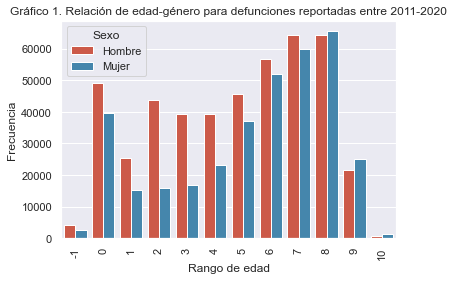

In [ ]:
# Debido a que es una diversa cantidad de edades, se decide hacer grupos
new_deaths = deaths.copy()

for x in range(11):
    if x < 10:
        new_deaths.loc[(new_deaths.Edadif >= x * 10) & (new_deaths.Edadif < (x+1) * 10), 'Edadif'] = x
    else:
       new_deaths.loc[(new_deaths.Edadif >= 100), 'Edadif'] = 10

age_gender = new_deaths.groupby(by=['Sexo', 'Edadif']).count()
age_gender.reset_index(level=[1], inplace=True)

ax = sns.barplot(x="Edadif", y="Depreg", hue=age_gender.index, data=age_gender)
ax.set(title='Gráfico 7. Relación de edad-género para defunciones reportadas entre 2011-2020',
       xlabel= 'Rango de edad',
       ylabel='Frecuencia')
plt.xticks(rotation=90)
plt.show()

del new_deaths, age_gender, ax

#### ¿Cuál es el porcentaje de población indígena que recibe asistencia hospitalaria?

Como se muestra en el **gráfico 5** solamente un 24% de las defunciones reportadas del pueblo indígena han recibido asistencia médica
a diferencia de un 70% de los cuales no ha recibido ningún tipo de asistencia.

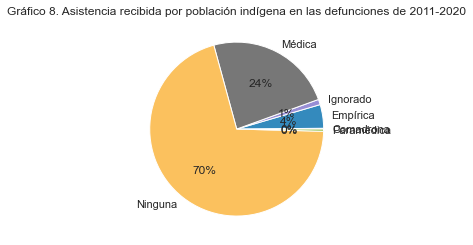

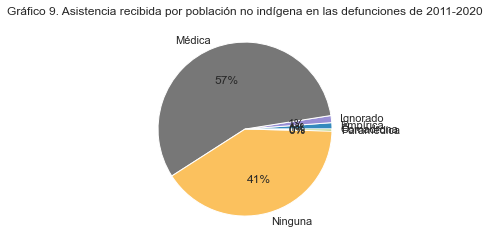

In [ ]:
etnic_asist = deaths.groupby(by=['Puedif', 'Asist']).count()
etnic_asist.reset_index(level=[1], inplace=True)
etnic_asist = etnic_asist.loc[ :, ['Asist', 'Depreg']]
etnic_asist['frequency (%)'] = (etnic_asist['Depreg'] / etnic_asist['Depreg'].sum()) * 100

etnic_asist_ind = etnic_asist.loc[etnic_asist.index == 'Indigena']
plt.pie(etnic_asist_ind.Depreg, labels = etnic_asist_ind.Asist, autopct='%.0f%%')
plt.title('Gráfico 8. Asistencia recibida por población indígena en las defunciones de 2011-2020')
plt.show()

etnic_asist_noind = etnic_asist.loc[etnic_asist.index == 'No indigena']
plt.pie(etnic_asist_noind.Depreg, labels = etnic_asist_noind.Asist, autopct='%.0f%%')
plt.title('Gráfico 9. Asistencia recibida por población no indígena en las defunciones de 2011-2020')
plt.show()

del etnic_asist, etnic_asist_noind, etnic_asist_ind

#### ¿Cómo es la distribución de las muertes de los jóvenes entre 18-30 que tienen una escolaridad por encima de diversificado?

De forma sencilla de interpretar el gráfico 6 representa la distribución de las muertes de personas entre 18-30 años agrupados por escolaridad. Como se puede notar,
con personas con grado académico igual y por encima de diversificado, la mayor cantidad de muertes se da justamente con grado académico de diversificado. Este resultado
es bastante interesante ya que si bien esto no presenta una relación entre nivel académico y muertes sino más bien, representa la desigualdad en acceso a educación que se vive
dentro del país, ya que como se puede notar, la cantidad de jóvenes, que fallecen y son universitarios es muy poca en comparación con aquellos que mueren y están estudiando o tienen
grado académico de primaria.

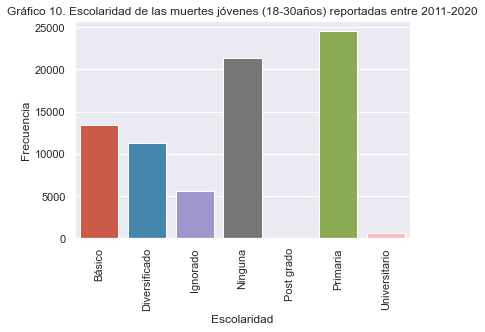

In [ ]:
young = deaths.loc[(deaths['Edadif'] >= 18) & (deaths['Edadif'] <= 30), ]
young = young.groupby(by=['Escodif']).count()

ax = sns.barplot(x=young.index, y="Depreg", data=young)
ax.set(title='Gráfico 10. Escolaridad de las muertes jóvenes (18-30años) reportadas entre 2011-2020',
       xlabel= 'Escolaridad',
       ylabel='Frecuencia')
plt.xticks(rotation=90)
plt.show()

del young, ax

### ¿En qué meses se dieron la mayor cantidad de defunciones?

Como se puede observar en la **gráfica 7**, los meses 3 con mayores defunciones son:
- Julio con 73553 muertes reportas,
- Agosto con 69865
- Diciembre con 69332

Mesocu
Julio         73553
Agosto        69865
Diciembre     69332
Octubre       68468
Enero         68213
Junio         67813
Marzo         66918
Septiembre    66696
Mayo          66551
Noviembre     66100
Abril         65316
Febrero       60471
Name: Mesocu, dtype: int64

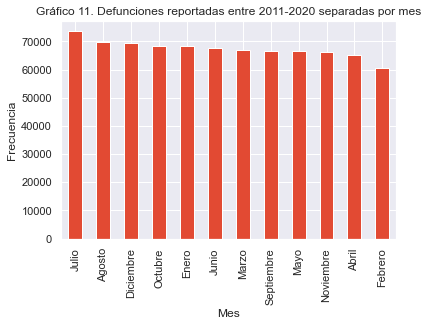

In [ ]:
month = deaths.groupby(["Mesocu"])["Mesocu"].count().sort_values(ascending=False)
display(month)

month.plot.bar()
plt.title('Gráfico 11. Defunciones reportadas entre 2011-2020 separadas por mes')
plt.xlabel('Mes')
plt.ylabel('Frecuencia')

del month

### ¿En qué países ocurrieron la mayor cantidad de defunciones en los años 2019 y 2020 (pandemia)?
El país con mayor defunciones es Guatemala. Cabe mencionar que este resultado se debe, principalmente, a que la mayoría
de datos que se recolectaron fueron dentro del país, obviando así muchos casos de defunciones de guatemaltecos que residen
en el extranjero.

Predif
Guatemala                    167596
Ignorado                      16302
Estados Unidos De América       148
El Salvador                      37
México                           26
Name: Predif, dtype: int64

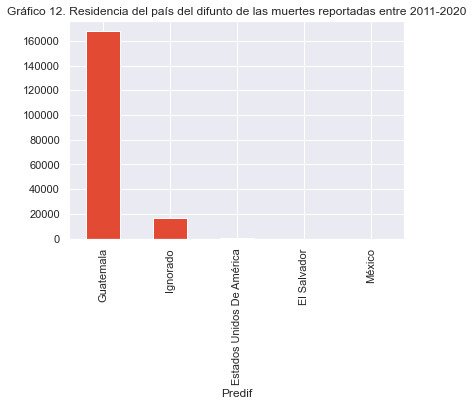

In [ ]:
pandemia = pd.DataFrame(deaths.query("Añoreg>=2019"))
pandemia['Edadif'] = [-1 if year == "Ignorado" else year for year in pandemia["Edadif"]]
pais = pandemia.groupby(["Predif"])["Predif"].count().sort_values(ascending=False).head()
display(pais)

pais.plot.bar()
plt.title('Gráfico 12. Residencia del país del difunto de las muertes reportadas entre 2011-2020')

del pais

### Durante estos años, las personas que fallecieron tuvieron tratamiento médico? 

Como se puede observar, la cantidad de defunciones que hubieron en estos años de pandemia y que recibieron asistencia médica
fueron de 93212 muertes, luego siguen las personas que no recibieron ningún tipo de asistencia médica. Esto se puede deber
a que en esos tiempo, muchas personas se enfermaban y cuando necesitaban ir a un hospital, estos se encontraban llenos y
no lograban encontrar cupo.

In [ ]:
display(pandemia.groupby("Asist")["Asist"].count().sort_values(ascending=False))

del pandemia

Asist
Médica        93212
Ninguna       80592
Ignorado       5860
Empírica       3683
Paramédica      671
Comadrona       129
Name: Asist, dtype: int64

### ¿Existe alguna relación entre el sexo y la atención recibida que tuvieron los fallecidos en los años 2011 a 2020?

Asist       Sexo  
Ninguna     Hombre    228798
Médica      Hombre    207723
            Mujer     172299
Ninguna     Mujer     169013
Empírica    Hombre      9465
            Mujer       8853
Ignorado    Hombre      6777
            Mujer       2705
Paramédica  Hombre      1893
            Mujer       1135
Comadrona   Mujer        391
            Hombre       244
Name: Asist, dtype: int64

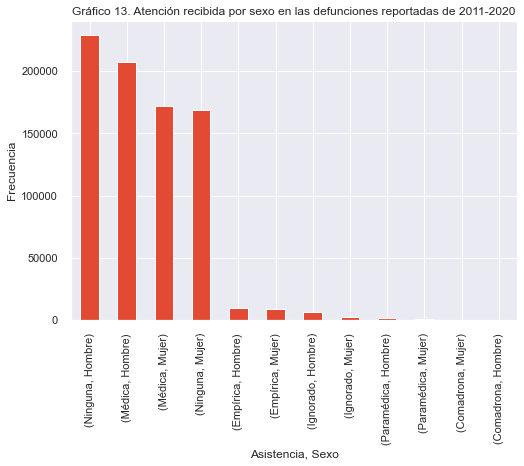

In [75]:
atencionGenero = deaths.groupby(["Asist","Sexo"])["Asist"].count().sort_values(ascending=False)
display(atencionGenero)

atencionGenero.plot.bar()
plt.title('Gráfico 13. Atención recibida por sexo en las defunciones reportadas de 2011-2020')
plt.xlabel('Asistencia, Sexo')
plt.ylabel('Frecuencia')

del atencionGenero

Como se puede observar en la **gráfica 9**, no hay alguna relación entre el género y la atención recibida, por lo que no
se puede concluir que el género afecte en algo hacia la atención médica que se puede recibir. Sin embargo, se puede notar
que sin importar el género, existe una gran cantidad de personas que no recibe atención médica antes de morir.

### ¿En Guatemala, en qué lugares predominan las defunciones? ¿El servicio que ofrecen los hospitales privados es mejor que el de los hospitales públicos? 

Mredif
Guatemala                80791
Mixco                    21792
Villa Nueva              16477
Quetzaltenango           10186
Escuintla                 9532
San Pedro Carchá          8691
San Juan Sacatepéquez     8587
Cobán                     7677
Jalapa                    7093
Totonicapán               6781
Name: Mredif, dtype: int64

Text(0.5, 0, '')

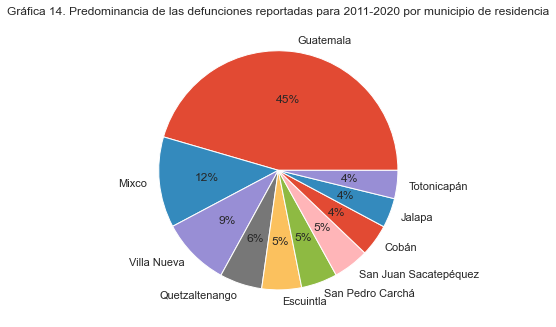

In [76]:
guatemala = pd.DataFrame(deaths.query("Predif=='Guatemala'"))
municipios = guatemala.groupby("Mredif")["Mredif"].count().sort_values(ascending=False).head(10)
display(municipios)

municipios.plot.pie(autopct='%.0f%%')
plt.title('Gráfica 14. Predominancia de las defunciones reportadas para 2011-2020 por municipio de residencia')
plt.ylabel('')
plt.xlabel('')

Ocur
Domicilio           429523
Hospital público    128415
Ignorado             37938
Seguro social        35107
Hospital privado     19461
Vía pública          19401
Otro                  7572
Centro de salud       1566
Lugar de trabajo        45
Name: Ocur, dtype: int64

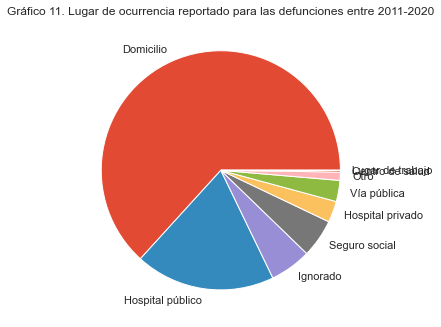

In [77]:
lugar = guatemala.groupby("Ocur")["Ocur"].count().sort_values(ascending=False).head(10)
display(lugar)

lugar.plot.pie()
plt.title('Gráfico 11. Lugar de ocurrencia reportado para las defunciones entre 2011-2020')
plt.ylabel('')
plt.xlabel('')

del guatemala, lugar, municipios

Cómo se puede observar en las dos gráficas de pie, el municipio con mayor cantidad de defunciones es Guatemala, luego le
sigue Mixco, Villa Nueva y Quetzaltenango. Por otro lado, se puede ver en el **gráfico 11** en los hospitales públicos
existió una mayor cantidad de defunciones que en hospitales privados, lo que podría indicar que el servicio de los
hospitales privados es mejor, sin embargo, como se vio en la pregunta anterior y en la siguiente pregunta,
el número de personas que tiene acceso a tratamientos médicos privados es muy baja,
por lo tal no es posible concluir que los hospitales privados son mejores que los públicos debido a que la cantidad
de personas que cuentan con los recursos económicos para asistir a un hospital privado es menos de la mitad de la población
guatemalteca.

### ¿Las personas fallecidas de 50 años o más recibieron buen tratamiento médico? 

In [78]:
datos2 = deaths.copy()
datos2['Edadif'] = [-1 if year == "Ignorado" else int (year) for year in datos2["Edadif"]]
mayores = pd.DataFrame(datos2.query("Edadif>49"))

display(mayores.groupby("Asist")["Asist"].count().sort_values(ascending=False))

del mayores, datos2

Asist
Ninguna       244804
Médica        233154
Empírica       11730
Ignorado        3915
Paramédica      1433
Comadrona        138
Name: Asist, dtype: int64

Cómo se mencionó anteriormente, aquí se puede observar que las personas mayores a los 50 años no recibieron asistencia
médica a la hora de su muerte, con una cantidad de 200701 defunciones registradas para ese caso. Luego siguen las
defunciones que sí recibieron asistencia médica, con un valor de 196730.

### ¿Quienes fueron las personas que más certificaron durante los años 2015 a 2020?

Cerdef
Médico        293734
Ignorado      213060
Autoridad       2915
Paramédico      2128
Name: Cerdef, dtype: int64

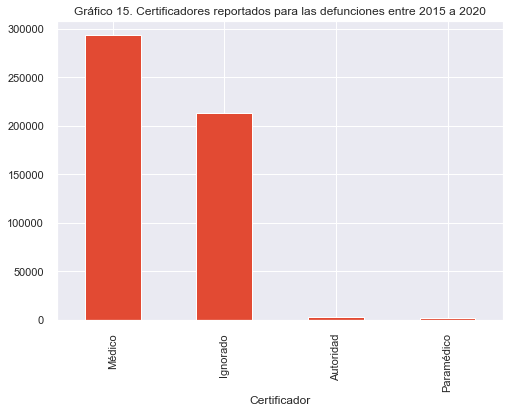

In [79]:
datos2 = pd.DataFrame(deaths.query("Añoreg>2014"))

cert = datos2.groupby("Cerdef")["Cerdef"].count().sort_values(ascending=False)
display(cert)

cert.plot.bar()
plt.title('Gráfico 15. Certificadores reportados para las defunciones entre 2015 a 2020')
plt.xlabel('Certificador')

del datos2

Como se puede observar en la gráfica de arriba, las personas que mayor certificaron son los médicos, seguidos por los
que se registraron como "ignorados".

### ¿Cuál es el porcentaje de las muertes por enfermedad que NO recibieron asistencia médica?
En el **gráfico 16** se puede observar que aproximadamente un 46% de las muertes a causa natural reportadas durante los años
2011 a 2020 no recibieron asistencia médica.

,Asist,count,frequency (%)
cause,,,
NC,Comadrona,618,0.090468
NC,Empírica,17680,2.588140
NC,Ignorado,4504,0.659332
NC,Médica,329644,48.255933
NC,Ninguna,328628,48.107203
NC,Paramédica,2042,0.298924


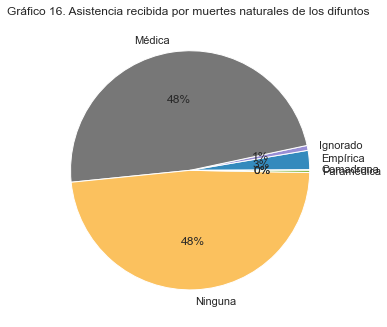

In [80]:
illness = pd.DataFrame({
    'Asist': deaths['Asist'],
    'cause' : deaths['cause'].replace(r'([A-R])([A-R])', r'NC', regex=True),
    'count': 1
}).groupby(['cause', 'Asist']).count()
illness.reset_index(level=[1], inplace=True)
illness = illness.loc[illness.index == 'NC']
illness['frequency (%)'] = (illness['count'] / illness['count'].sum()) * 100
display(illness)

plt.pie(illness['frequency (%)'], labels = illness.Asist, autopct='%.0f%%')
plt.title('Gráfico 16. Asistencia recibida por muertes naturales de los difuntos ')
plt.show()

del illness

### ¿Cuál es el porcentaje de las muertes por causa externa (i.e. no causa natural) que recibieron asistencia médica?
Como se puede notar en el **gráfico 17** únicamente un 40% de las muertes reportadas por causas externas recibieron asistencia
médica, dejando así, un 55% de difuntos sin asistencia médica.

,Asist,count,frequency (%)
cause,,,
EC,Comadrona,17,0.013473
EC,Empírica,638,0.505627
EC,Ignorado,4978,3.945158
EC,Médica,50378,39.925503
EC,Ninguna,69183,54.828816
EC,Paramédica,986,0.781423


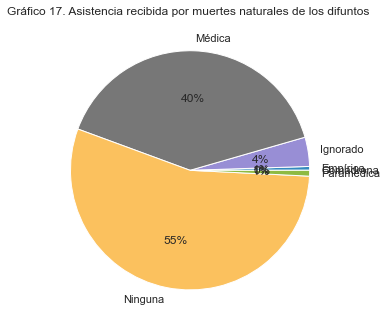

In [81]:
illness = pd.DataFrame({
    'Asist': deaths['Asist'],
    'cause' : deaths['cause'].replace(r'([S-Y])([S-Y])', r'EC', regex=True),
    'count': 1
}).groupby(['cause', 'Asist']).count()
illness.reset_index(level=[1], inplace=True)
illness = illness.loc[illness.index == 'EC']
illness['frequency (%)'] = (illness['count'] / illness['count'].sum()) * 100
display(illness)

plt.pie(illness['frequency (%)'], labels = illness.Asist, autopct='%.0f%%')
plt.title('Gráfico 17. Asistencia recibida por muertes naturales de los difuntos ')
plt.show()

del illness


## Agrupamiento
Haga un agrupamiento (clustering) e interprete los resultados.
Para la elaboración del agrupamiento, debido a que se cuenta con una gran cantidad de datos, sin embargo no se tiene a
disposición un ordenador capaz de procesar dicha cantidad de datos, entonces se decidió utilizar una muestra de la población.

Debido a que se busca que la muestra sea lo más significativa posible, se decidió tomar aproximadamente un 15% de los datos
de cada año y así garantizar que en la muestra existirá una proporción de defunciones de todos los años descritos en la población
original.

Al ser únicamente variables categóricas se utilizará como algoritmo de agrupamiento k-modes. El cual es una variante de k-means
pero en lugar de tomar la distancia entre los datos, este se basa en la moda de los mismos.

In [7]:
# Obtención de la muestra
deaths_sample = deaths.groupby('Añoocu', group_keys=False).apply(lambda x: x.sample(frac=0.15, random_state=191943))

usable = ['Asist', 'Depreg', 'Mupreg', 'Añoreg', 'Puedif', 'cause', 'Ocur', 'Cerdef']
deaths_sample = deaths_sample[usable]

### Número óptimo de clusters.

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 406650.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 406650.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 406650.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 406650.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 406650.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10720, cost: 344347.0
Run 1, iteration: 2/100, moves: 696, cost: 344347.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 6840, cost: 344220.0
Init: ini

Text(0.5, 1.0, 'Método de Codo para el Número óptimo de Clusters K-Modes')

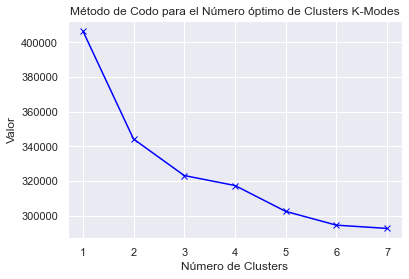

In [153]:
# Elbow curve to find optimal K
cost = []
K = range(1,8)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init="random", n_init = 5, verbose=1)
    kmode.fit_predict(deaths_sample)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('Número de Clusters')
plt.ylabel('Valor')
plt.title('Método de Codo para el Número óptimo de Clusters K-Modes')

Mediante el gráfico del codo se puede observar que para el conjunto de datos a agrupar el número óptimo de clusters
es 3, ya que es en este punto que al aumentar la cantidad de clusters el valor no cambia significativamente.

### Uso de algoritmo de agrupamiento.

In [15]:
kmode = KModes(n_clusters=3, init="random", n_init = 5, verbose=1, random_state=42)
clusters = kmode.fit_predict(deaths_sample)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 40752, cost: 501263.0
Run 1, iteration: 2/100, moves: 13214, cost: 498855.0
Run 1, iteration: 3/100, moves: 1228, cost: 498855.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 23904, cost: 492815.0
Run 2, iteration: 2/100, moves: 1017, cost: 492815.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 14487, cost: 487684.0
Run 3, iteration: 2/100, moves: 672, cost: 487684.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 13464, cost: 490828.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 60245, cost: 488541.0
Run 5, iteration: 2/100, moves: 21691, cost: 488541.0
Best run was number 3


array([0, 1, 1, ..., 0, 0, 1], dtype=uint16)

In [16]:
binary_sample = pd.get_dummies(deaths_sample)

### Calidad del agrupamiento usando el método de la silueta.

For n_clusters = 3 The average silhouette_score is : 0.014126839158191157


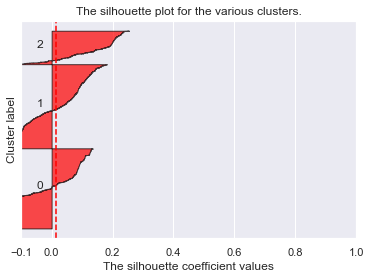

In [17]:
# plt.figure.size_inches(18, 7)
plt.xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
# plt.set_ylim([0, len(X) + (n_clusters + 1) * 10])

silhouette_avg = silhouette_score(binary_sample, clusters)
print("For n_clusters = 3 The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(binary_sample, clusters)

y_lower = 10
for i in range(3):
    ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # color = cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor='red',
        edgecolor='black',
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

In [18]:
# Agregando los resultados del cluster al dataframe
deaths_sample['cluster'] = clusters

### Interpretación de los grupos, usando para eso las variables numéricas y categóricas dentro de cada grupo.
Para hacer el análisis y la interpretación de los resultados del cluster se utilizó la visualización de los mismos, es
decir, se observó gráficamente cómo se había realizado la división en los grupos mediante gráfico de barras.

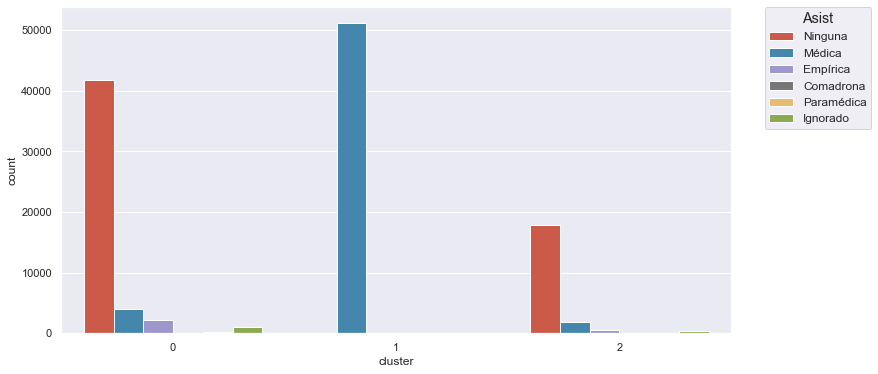

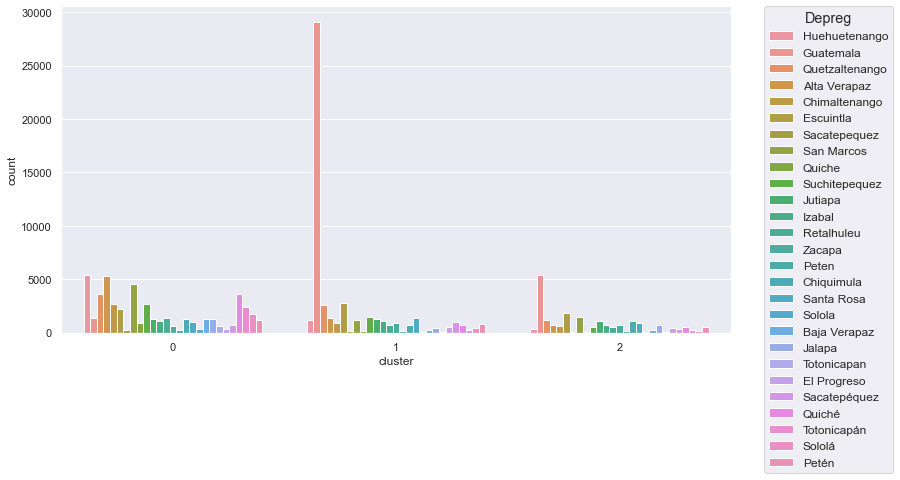

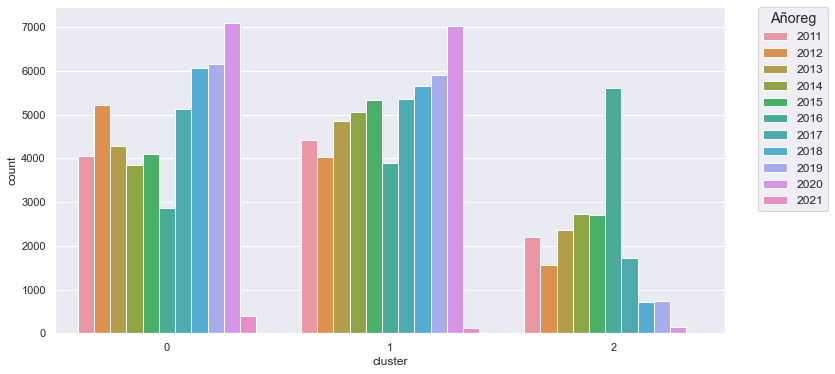

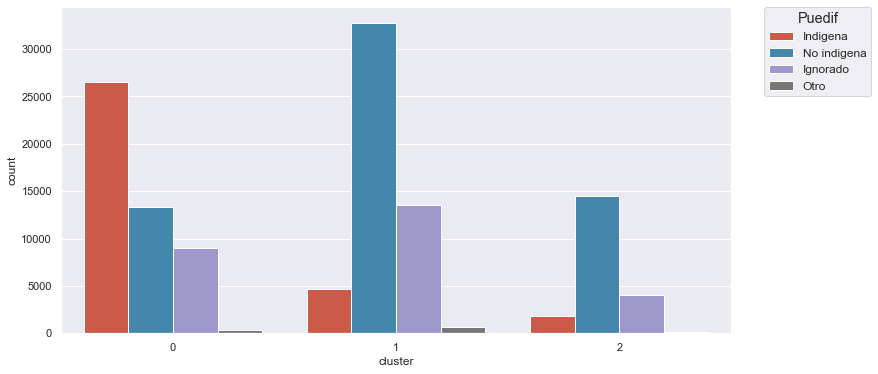

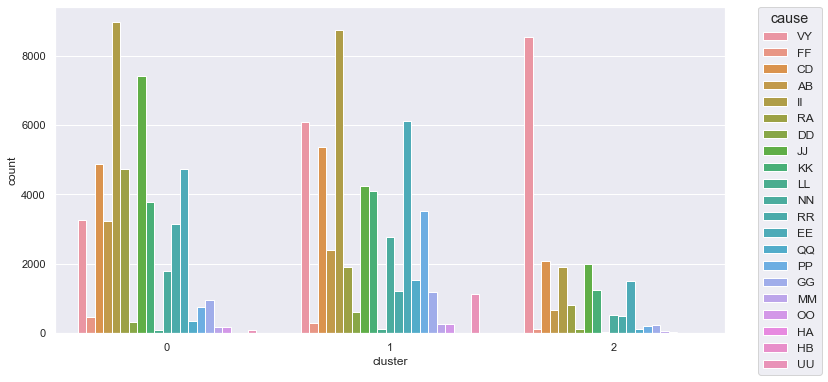

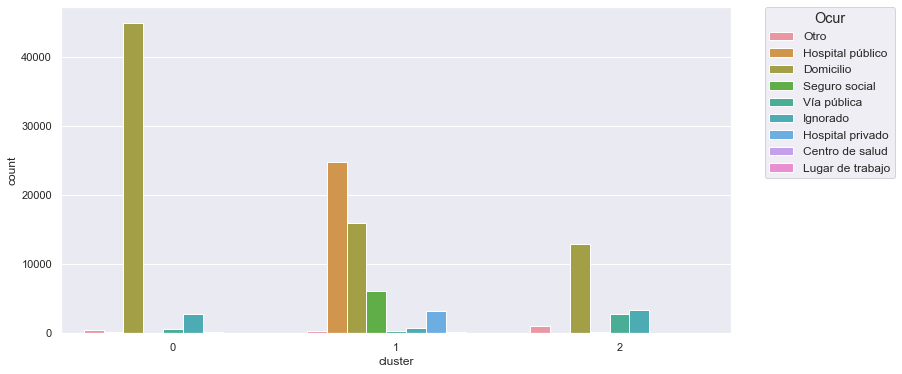

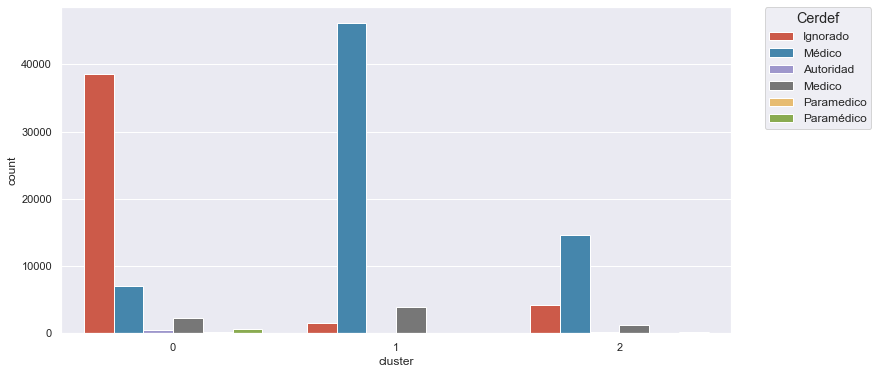

In [20]:
variables = ['Asist', 'Depreg', 'Añoreg', 'Puedif', 'cause', 'Ocur', 'Cerdef']

for variable in variables:
    plt.figure(figsize=(12,6))
    ax = sns.countplot(x="cluster", hue=variable, data=deaths_sample)
    plt.legend(bbox_to_anchor=(1.05, 1),
               loc='upper left',
               borderaxespad=0,
               title=variable,
               fontsize='medium',
               title_fontsize='large')
    plt.show(ax)

En las gráficas anteriores se puede notar que si bien en cada grupo no se encuentra una sola categoría de cada variable
sin embargo, si es fácil de observar que existe una categoría que predomina.

En el caso del grupo 1, predominan las personas que no recibieron ningún tipo de asistencia a la hora de morir, especialmente en los
departamentos de Huehuetenango, San Marcos y Alta Verapaz, siendo su principal población perteneciente al pueblo indígena.
Como principales causas de muerte las enfermedades del aparato circulatorio y enfermedades del aparato respiratorio. Estas muertes
en mayoría ocurrieron en los domiciolios de los difuntos. Y debido a esto, se desconoce quién hizo la certificación de muerte.

Por otro lado se tiene al grupo 2, en el cual se encuentran los difuntos que recibieron asistencia médica, principalmente
en el departamento de Guatemala alrededor del año 2019 - 2020 siendo en su mayoría personas no indígenas con causa principal
de muerte por enfermedades del aparato circulatorio seguido por enfermedades metabólicas, endocrinas y nutricionales.
Estas muertes principalmente han ocurrido en hospitales públicos y domicilios y por lo tal, han sido en su mayoría, certificadas por un
médico.

Finalmente se tiene al grupo 3, este cuenta con observaciones que en su mayoría  no recibieron asistencia médica, siendo estos principalmetne
residentes del departamento de Guatemala alrededor del año 2015, en su mayoría es población no indígena cuya muerte ha ocurrido principalmente a causa
de situaciones externas tales como accidentes automovilísticos, lesiones autoinflingidas o lesiones a causua de accidentes.
En este grupo predominan los fallecimientos en los domicilios y la certificación ha sido dada, en su mayoría, por un médico.

# Análisis de resultados

## Situación problemática
Describa la situación problemática que lo lleva a acotar un problema a resolver.

Durante el análisis exploratorio realizada en el apartado anterior se pudo encontrar que aproximadamente el 50% de los datos
reportados para las defunciones de los años de 2011 a 2020 no recibe ningún tipo de asistencia al morir. De igual forma se buscó
analizar si existía algún tipo de sesgo en cuanto a la asistencia dependiendo del pueblo de pertenencia del difunto, y como se
puede observar en el **gráfico 5.1** y **gráfico 5.2** en el caso de la población indígena, solamente un 24% de la población
recibe asistencia médica, a diferencia de la población no indígena, de la cual aproximadamente un 57% recibe asistencia médica.

Algo interesante a notar es que el sexo no establece un marco de sesgo para la atención 

## Problema científico
Enuncie un problema científico y unos objetivos preliminares.


## ¿Qué se tiene para responder el problema?
Describa los datos que tiene para responder el problema planteado. Esto incluye el estado en que encontró el o los conjuntos
de datos y las operaciones de limpieza que le realizó, en caso de que hayan sido necesarias.

## Conclusiones
Escriba unas conclusiones con los hallazgos encontrados durante el análisis exploratorio

Una de las cosas más interesantes al analizar los datos, tanto mediante el análisis exploratorio como mediante el agrupamiento
fue el encontrar el "sesgo" o preferencia que existe al proporcionar asistencia médica, ya que esta principalmente se provee a
personas que no pertenecen al pueblo indígena y que residen en el departamento de Guatemala.